In [1]:
!pip install transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [2]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
import evaluate

2025-09-18 18:57:34.934496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758221855.305050      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758221855.413267      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path = '/kaggle/input/fake-news-data/Train_1.csv'
test_path = '/kaggle/input/fake-news-data/Test1.csv'
valid_path = '/kaggle/input/fake-news-data/Valid1.csv'

train_df = pd.read_csv(train_path, )
test_df = pd.read_csv(test_path, )
val_df = pd.read_csv(valid_path, )


In [5]:
train_df.shape

(35918, 5)

In [4]:
train_df.head()

,title,text,subject,date,label
0,Kellyanne Conway’s Husband Just Publicly Bash...,So the Conway marriage just took a turn and ...,News,"June 5, 2017",0
1,JEB BUSH WANTS CONGRESS TO APPROVE AMNESTY And...,Jeb Bush just unofficially placed himself on t...,politics,"Apr 17, 2015",0
2,"Henningsen on Trump’s Foreign Policy: Russia, ...",21st Century Wire says While the US media con...,Middle-east,"November 21, 2016",0
3,"Netanyahu lauds Trump's Iran turn, sees chance...",JERUSALEM (Reuters) - Israeli Prime Minister B...,worldnews,"October 13, 2017",1
4,WATCH PRESIDENT TRUMP’S MOST SAVAGE MOMENTS….P...,Here s a compilation of President Trump s most...,politics,"May 8, 2017",0


In [5]:
test_df.head()

,title,text,subject,date,label
0,PULITZER PRIZE WINNING AUTHOR TONI MORRISON: “...,The recipient of the Presidential Medal of Fre...,left-news,"Apr 22, 2015",0
1,CLINTON FOUNDATION DONORS GOT SWEET WEAPONS DE...,"Nothing shady here, huh? Unbelievable!Even by ...",politics,"May 26, 2015",0
2,Trump Accidentally Applauds Obama’s Protectio...,Republican front runner Donald Trump loves to ...,News,"February 16, 2016",0
3,EPA exercises enforcement discretion for all F...,WASHINGTON (Reuters) - The Environmental Prote...,worldnews,"September 11, 2017",1
4,THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...,Hillary Clinton s supporters were calling cert...,Government News,"Apr 12, 2015",0


# ***Tokenizer***

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [7]:
# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

# ***Load Model***

In [9]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased", num_labels=2
)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ***Training***


In [10]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

In [13]:
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    # evaluation_strategy="epoch", # Removed this
    # save_strategy="epoch", # Keep this commented out for now
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_distilbert",
    report_to="none"  # disable wandb
)

# Try setting eval_strategy after initialization
training_args.eval_strategy = "epoch"

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_36/3788975122.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.002400,0.000010,1.000000,1.000000,1.000000,1.000000
2,0.002800,0.000008,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=13470, training_loss=0.00431420548175826, metrics={'train_runtime': 3330.3071, 'train_samples_per_second': 32.356, 'train_steps_per_second': 4.045, 'total_flos': 7136946037389312.0, 'train_loss': 0.00431420548175826, 'epoch': 3.0})

In [15]:
results = trainer.evaluate()
print("Final Results (DistilBERT):", results)

Final Results (DistilBERT): {'eval_loss': 1.508032482888666e-06, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 31.5411, 'eval_samples_per_second': 142.354, 'eval_steps_per_second': 17.818, 'epoch': 3.0}


# ***Results Analysis***

# ***1. Predictions on Train DataSet***

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(tokenized_train_dataset)
x_true = predictions.label_ids
x_pred = np.argmax(predictions.predictions, axis=1)

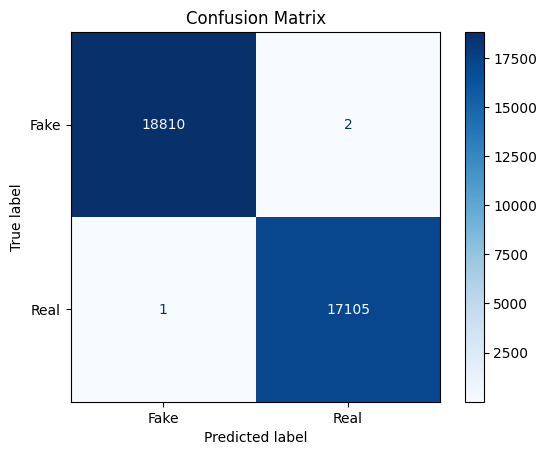

In [21]:
cm = confusion_matrix(x_true, x_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [22]:
print("Classification Report:")
print(classification_report(x_true, x_pred, target_names=["Fake", "Real"]))


Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     18812
        Real       1.00      1.00      1.00     17106

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918



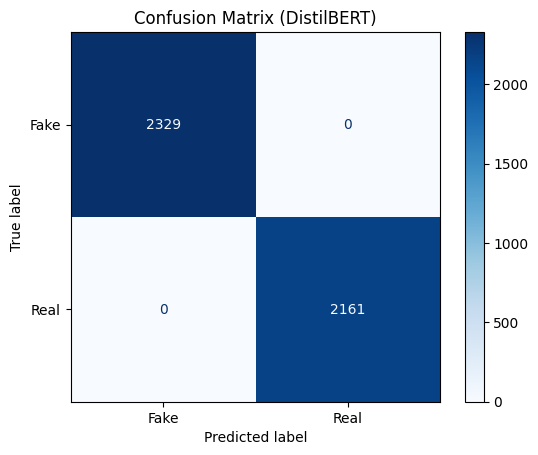

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (DistilBERT)")
plt.show()

# ***1. Predictions on Test DataSet***

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(tokenized_test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

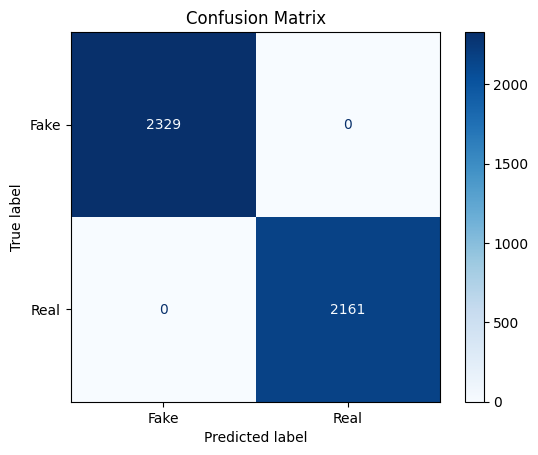

In [25]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [26]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))


Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      2329
        Real       1.00      1.00      1.00      2161

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



# ***2. ROC Curve & AUC***

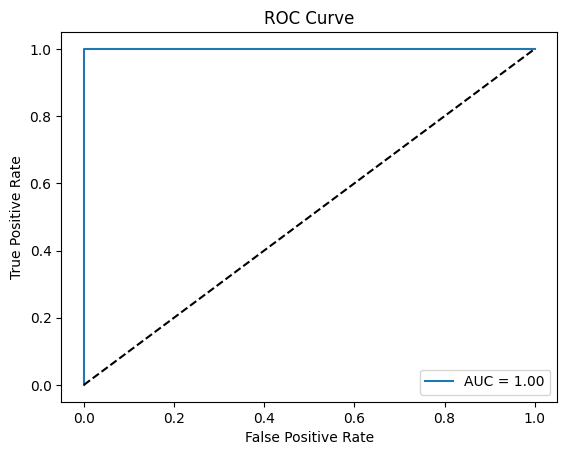

In [27]:
from sklearn.metrics import roc_curve, auc

y_probs = predictions.predictions[:,1]  # probability for "Real" class
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], "k--")  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# ***3. Precision-Recall Curve***

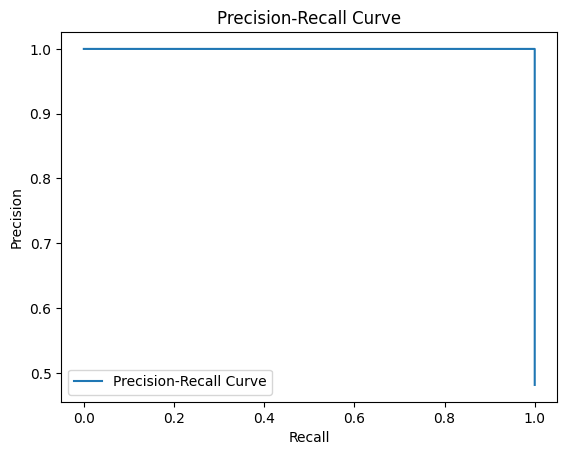

In [28]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_true, y_probs)

plt.figure()
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


# ***Learning curves (training vs validation loss / accuracy)***

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# extract history (works if trainer logged eval and train losses)
history = trainer.state.log_history  # list of dicts

In [30]:
# parse into per-epoch lists
train_losses = []
eval_losses = []
eval_acc = []
eval_prec = []
eval_rec = []
eval_f1 = []
epochs = []

for record in history:
    # records include step, loss, eval_loss, epoch, eval_accuracy, etc.
    if 'loss' in record and 'epoch' in record:
        # training loss logged at steps; keep last per epoch
        train_losses.append((record['epoch'], record['loss']))
    if 'eval_loss' in record:
        epochs.append(record.get('epoch', len(epochs)+1))
        eval_losses.append(record['eval_loss'])
        # optional metrics (if compute_metrics returns them)
        eval_acc.append(record.get('eval_accuracy', np.nan))
        eval_prec.append(record.get('eval_precision', np.nan))
        eval_rec.append(record.get('eval_recall', np.nan))
        eval_f1.append(record.get('eval_f1', np.nan))

# Convert to arrays aligned by epoch
# For training loss we take last loss value per epoch
if train_losses:
    # dict epoch->loss (keep last logged loss for each epoch)
    ep_train = {}
    for ep, loss in train_losses:
        ep_train[ep] = loss
    train_epochs = sorted(ep_train.keys())
    train_loss_vals = [ep_train[e] for e in train_epochs]
else:
    train_epochs, train_loss_vals = [], []

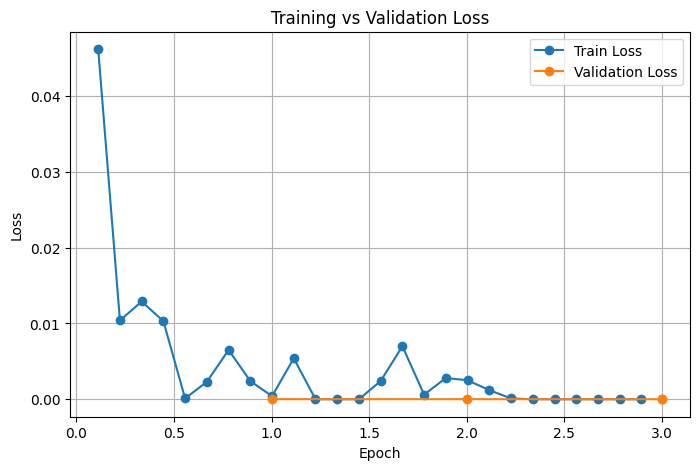

In [31]:
# Plot losses
plt.figure(figsize=(8,5))
if train_loss_vals:
    plt.plot(train_epochs, train_loss_vals, label='Train Loss', marker='o')
if epochs:
    plt.plot(epochs, eval_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



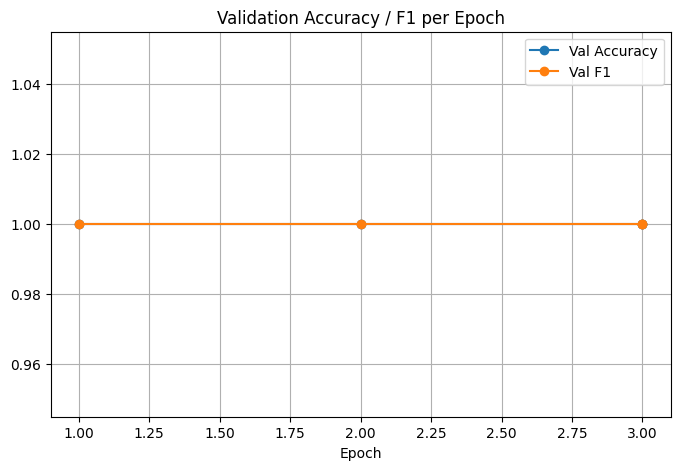

In [32]:
# Plot accuracy/F1 if available
if any(np.isfinite(eval_acc)):
    plt.figure(figsize=(8,5))
    plt.plot(epochs, eval_acc, label='Val Accuracy', marker='o')
    if any(np.isfinite(eval_f1)):
        plt.plot(epochs, eval_f1, label='Val F1', marker='o')
    plt.xlabel('Epoch')
    plt.title('Validation Accuracy / F1 per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# ***5-Fold Cross-Validation (Hugging Face Trainer)***

In [15]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Convert dataframe into lists
texts = train_df['text'].tolist()
labels = train_df['label'].tolist()

print("Dataset size:", len(texts))


Dataset size: 35918


In [20]:
# Use 5 folds for cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Debug: print sizes for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df), 1):
    print(f"Fold {fold}: Train size={len(train_idx)}, Val size={len(val_idx)}")


Fold 1: Train size=23945, Val size=11973
Fold 2: Train size=23945, Val size=11973
Fold 3: Train size=23946, Val size=11972


In [21]:
# Pick model + tokenizer
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset wrapper
class HFTextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.enc = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [23]:
fold_metrics = []  # to store results
fold_idx = 1


In [25]:
import evaluate

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }


for train_idx, val_idx in kf.split(texts):
    print(f"\n=== Fold {fold_idx}/3 ===")

    # Split dataset
    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}")

    # Build datasets
    train_dataset = HFTextDataset(train_texts, train_labels, tokenizer)
    val_dataset = HFTextDataset(val_texts, val_labels, tokenizer)

    # Reload model fresh each fold
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./cv_results/fold_{fold_idx}",
        eval_strategy="epoch", # Changed from evaluation_strategy
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir=f"./cv_logs/fold_{fold_idx}",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics  # your function
    )

    # Train + evaluate
    trainer.train()
    metrics = trainer.evaluate()

    print(f"Fold {fold_idx} metrics: {metrics}")

    # Save results
    fold_metrics.append({
        "fold": fold_idx,
        "accuracy": metrics.get("eval_accuracy", np.nan),
        "precision": metrics.get("eval_precision", np.nan),
        "recall": metrics.get("eval_recall", np.nan),
        "f1": metrics.get("eval_f1", np.nan)
    })

    fold_idx += 1


=== Fold 1/3 ===
Train size: 23945, Val size: 11973


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.001200,0.001674,0.999749,0.999750,0.999749,0.999749
2,0.000500,0.000833,0.999916,0.999916,0.999916,0.999916


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 1 metrics: {'eval_loss': 0.0008329256670549512, 'eval_accuracy': 0.9999164787438403, 'eval_precision': 0.999916492075246, 'eval_recall': 0.9999164787438403, 'eval_f1': 0.9999164784191994, 'eval_runtime': 60.8403, 'eval_samples_per_second': 196.794, 'eval_steps_per_second': 6.164, 'epoch': 2.0}

=== Fold 2/3 ===
Train size: 23945, Val size: 11973


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.005700,0.001476,0.999833,0.999833,0.999833,0.999833
2,0.001000,0.000986,0.999833,0.999833,0.999833,0.999833


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 2 metrics: {'eval_loss': 0.000986495055258274, 'eval_accuracy': 0.9998329574876806, 'eval_precision': 0.9998329574876806, 'eval_recall': 0.9998329574876806, 'eval_f1': 0.9998329574876806, 'eval_runtime': 60.8087, 'eval_samples_per_second': 196.896, 'eval_steps_per_second': 6.167, 'epoch': 2.0}

=== Fold 3/3 ===
Train size: 23946, Val size: 11972


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.004700,0.003701,0.999499,0.999499,0.999499,0.999499
2,0.000300,0.003176,0.999499,0.999499,0.999499,0.999499


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 3 metrics: {'eval_loss': 0.0031756004318594933, 'eval_accuracy': 0.9994988306047444, 'eval_precision': 0.9994988791845734, 'eval_recall': 0.9994988306047444, 'eval_f1': 0.9994988269472973, 'eval_runtime': 60.824, 'eval_samples_per_second': 196.83, 'eval_steps_per_second': 6.165, 'epoch': 2.0}


In [26]:
df_folds = pd.DataFrame(fold_metrics)

print("\n=== CV Results by Fold ===")
print(df_folds)

print("\n=== Final Mean ± Std ===")
print(df_folds.mean(numeric_only=True))
print(df_folds.std(numeric_only=True))



=== CV Results by Fold ===
   fold  accuracy  precision    recall        f1
0     1  0.999916   0.999916  0.999916  0.999916
1     2  0.999833   0.999833  0.999833  0.999833
2     3  0.999499   0.999499  0.999499  0.999499

=== Final Mean ± Std ===
fold         2.000000
accuracy     0.999749
precision    0.999749
recall       0.999749
f1           0.999749
dtype: float64
fold         1.000000
accuracy     0.000221
precision    0.000221
recall       0.000221
f1           0.000221
dtype: float64


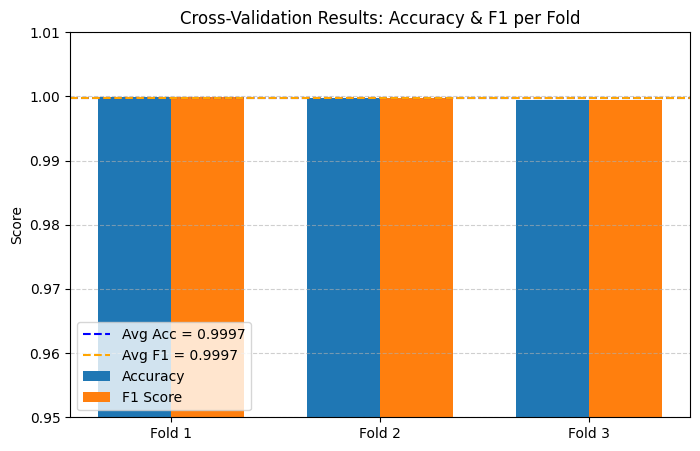

In [27]:
import matplotlib.pyplot as plt

# Extract fold numbers and metrics
folds = df_folds['fold']
accuracy = df_folds['accuracy']
f1 = df_folds['f1']

# Plot
plt.figure(figsize=(8,5))
bar_width = 0.35
x = np.arange(len(folds))

# Bars for Accuracy & F1
plt.bar(x - bar_width/2, accuracy, width=bar_width, label="Accuracy")
plt.bar(x + bar_width/2, f1, width=bar_width, label="F1 Score")

# Add average lines
plt.axhline(y=accuracy.mean(), color="blue", linestyle="--", label=f"Avg Acc = {accuracy.mean():.4f}")
plt.axhline(y=f1.mean(), color="orange", linestyle="--", label=f"Avg F1 = {f1.mean():.4f}")

# Labels & title
plt.xticks(x, [f"Fold {i}" for i in folds])
plt.ylabel("Score")
plt.ylim(0.95, 1.01)  # zoom in for high scores
plt.title("Cross-Validation Results: Accuracy & F1 per Fold")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


# ***Class Distribution (Full Dataset)***

In [38]:
# Count samples per class in full dataset
class_counts = train_df['label'].value_counts().sort_index()

# Create a summary table
distribution = pd.DataFrame({
    "Class": ["Fake (0)", "Real (1)"],
    "Count": [class_counts[0], class_counts[1]],
    "Percentage": [class_counts[0]/len(train_df)*100, class_counts[1]/len(train_df)*100]
})

print("\n=== Class Distribution (Full Dataset) ===")
print(distribution)

# If you also want train/val/test split distributions:
from sklearn.model_selection import train_test_split

# Using the deduplicated train_df for splitting
train_df_split, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
train_df_split, val_df = train_test_split(train_df_split, test_size=0.1, stratify=train_df_split['label'], random_state=42)

def get_distribution(name, subset):
    counts = subset['label'].value_counts().sort_index()
    return {
        "Split": name,
        "Fake (0)": counts[0] if 0 in counts else 0,
        "Real (1)": counts[1] if 1 in counts else 0,
        "Total": len(subset)
    }

split_distribution = pd.DataFrame([
    get_distribution("Train", train_df_split),
    get_distribution("Validation", val_df),
    get_distribution("Test", test_df)
])

print("\n=== Split-wise Distribution ===")
print(split_distribution)


=== Class Distribution (Full Dataset) ===
      Class  Count  Percentage
0  Fake (0)  18812   52.374854
1  Real (1)  17106   47.625146

=== Split-wise Distribution ===
        Split  Fake (0)  Real (1)  Total
0       Train     13544     12316  25860
1  Validation      1505      1369   2874
2        Test      3763      3421   7184


/tmp/ipython-input-1330225586.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Fake (0)", "Real (1)"], y=class_counts.values, palette="Blues")


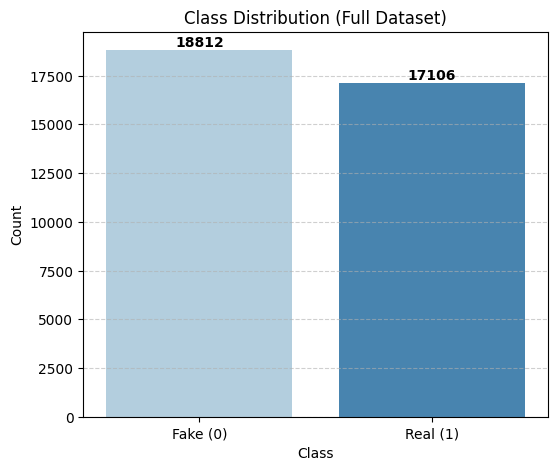

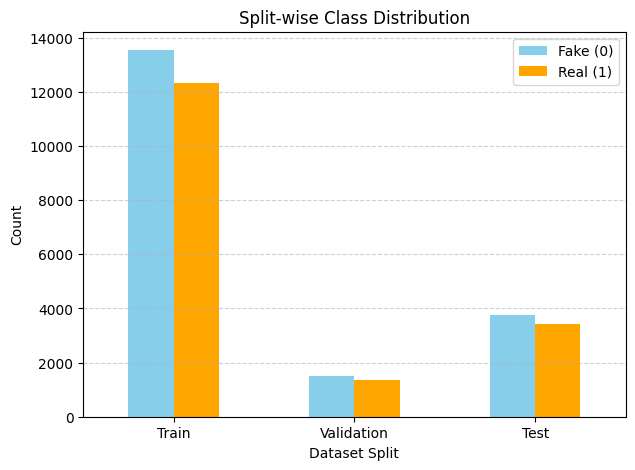

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Full dataset distribution ---
class_counts = train_df['label'].value_counts().sort_index()

plt.figure(figsize=(6,5))
sns.barplot(x=["Fake (0)", "Real (1)"], y=class_counts.values, palette="Blues")
plt.title("Class Distribution (Full Dataset)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 200, str(v), ha='center', fontweight='bold')
plt.show()

# --- Split-wise distribution ---
splits = ["Train", "Validation", "Test"]
split_counts = [
    train_df_split['label'].value_counts().sort_index(),
    val_df['label'].value_counts().sort_index(),
    test_df['label'].value_counts().sort_index()
]

split_df = pd.DataFrame(split_counts, index=splits)
split_df.plot(kind="bar", stacked=False, figsize=(7,5), color=["skyblue","orange"])

plt.title("Split-wise Class Distribution")
plt.ylabel("Count")
plt.xlabel("Dataset Split")
plt.xticks(rotation=0)
plt.legend(["Fake (0)", "Real (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ***Prediction***

In [28]:
import glob
import os
import numpy as np
import torch
import pandas as pd

# Path to all your SEMrush/MOZ CSVs
input_folder = "/kaggle/input/backlinks-data-cleaned"   # <-- change dataset name
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))

print(f"📂 Found {len(csv_files)} CSV files")

results_summary = []

for file in csv_files:
    # === 1. Load CSV ===
    df = pd.read_csv(file)
    print(f"\nProcessing file: {os.path.basename(file)} | Rows: {len(df)}")

    # === 2. Ensure "text" column ===
    if "text" not in df.columns:
        for col in ["content","body","article","headline","title"]:
            if col in df.columns:
                df = df.rename(columns={col: "text"})
                print(f"ℹ️ Renamed column '{col}' → 'text'")
                break

    texts = df["text"].astype(str).tolist()

    # === 3. Create Dataset ===
    class NewsDataset(torch.utils.data.Dataset):
        def __init__(self, texts, tokenizer, max_length=256):
            self.enc = tokenizer(
                texts, truncation=True, padding="max_length", max_length=max_length
            )

        def __len__(self):
            return len(self.enc["input_ids"])

        def __getitem__(self, idx):
            return {k: torch.tensor(v[idx]) for k, v in self.enc.items()}

    pred_dataset = NewsDataset(texts, tokenizer)

    # === 4. Run Predictions ===
    predictions = trainer.predict(pred_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:,1].numpy()

    # === 5. Attach Predictions ===
    df["Prediction"] = y_pred
    df["Prediction"] = df["Prediction"].map({0: "Fake", 1: "Real"})
    df["Confidence"] = y_probs

    # === 6. Save File to /kaggle/working ===
    output_file = f"/kaggle/working/{os.path.basename(file).replace('.csv','_pred_1.csv')}"
    df.to_csv(output_file, index=False)
    print(f"✅ Saved predictions to {output_file}")

    # === 7. Collect Summary ===
    results_summary.append({
        "File": os.path.basename(file),
        "Total Rows": len(df),
        "Real Count": (df["Prediction"]=="Real").sum(),
        "Fake Count": (df["Prediction"]=="Fake").sum(),
        "Avg Confidence": df["Confidence"].mean()
    })

# === 8. Save Summary Report ===
summary_df = pd.DataFrame(results_summary)
summary_path = "/kaggle/working/predictions_summary.csv"
summary_df.to_csv(summary_path, index=False)

print("\n📊 Summary of all files saved to:", summary_path)
summary_df


📂 Found 5 CSV files

Processing file: sdg_news_01_cleaned.csv | Rows: 32
✅ Saved predictions to /kaggle/working/sdg_news_01_cleaned_pred_1.csv

Processing file: rt_news_cleaned.csv | Rows: 1540


✅ Saved predictions to /kaggle/working/rt_news_cleaned_pred_1.csv

Processing file: gt_news_cleaned_04.csv | Rows: 1256


✅ Saved predictions to /kaggle/working/gt_news_cleaned_04_pred_1.csv

Processing file: euro_news_clean.csv | Rows: 3271


✅ Saved predictions to /kaggle/working/euro_news_clean_pred_1.csv

Processing file: inian_news_cleaned.csv | Rows: 501


✅ Saved predictions to /kaggle/working/inian_news_cleaned_pred_1.csv

📊 Summary of all files saved to: /kaggle/working/predictions_summary.csv


,File,Total Rows,Real Count,Fake Count,Avg Confidence
0,sdg_news_01_cleaned.csv,32,11,21,0.351368
1,rt_news_cleaned.csv,1540,961,579,0.620955
2,gt_news_cleaned_04.csv,1256,950,306,0.754814
3,euro_news_clean.csv,3271,1742,1529,0.536908
4,inian_news_cleaned.csv,501,226,275,0.418176


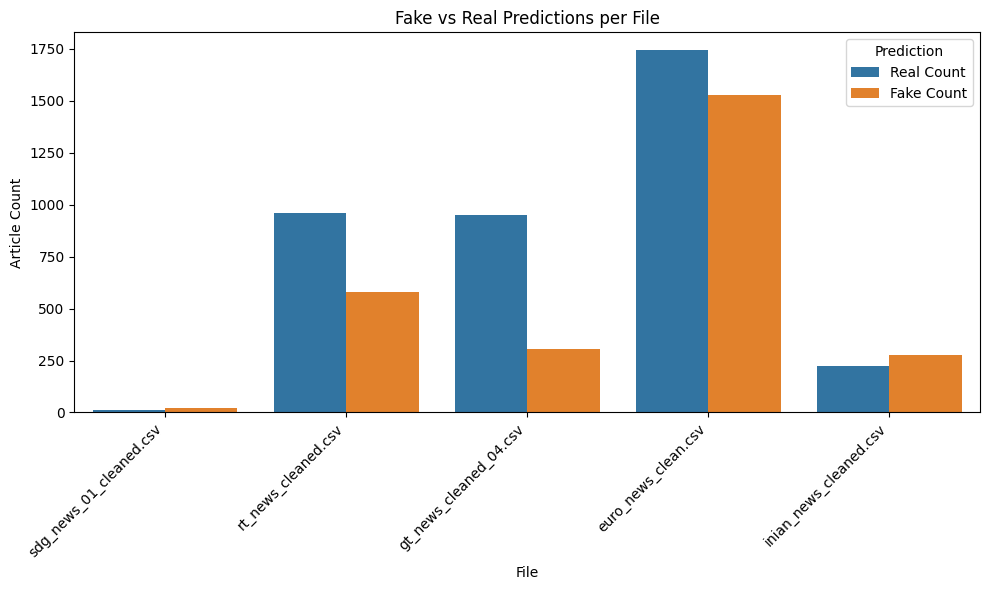

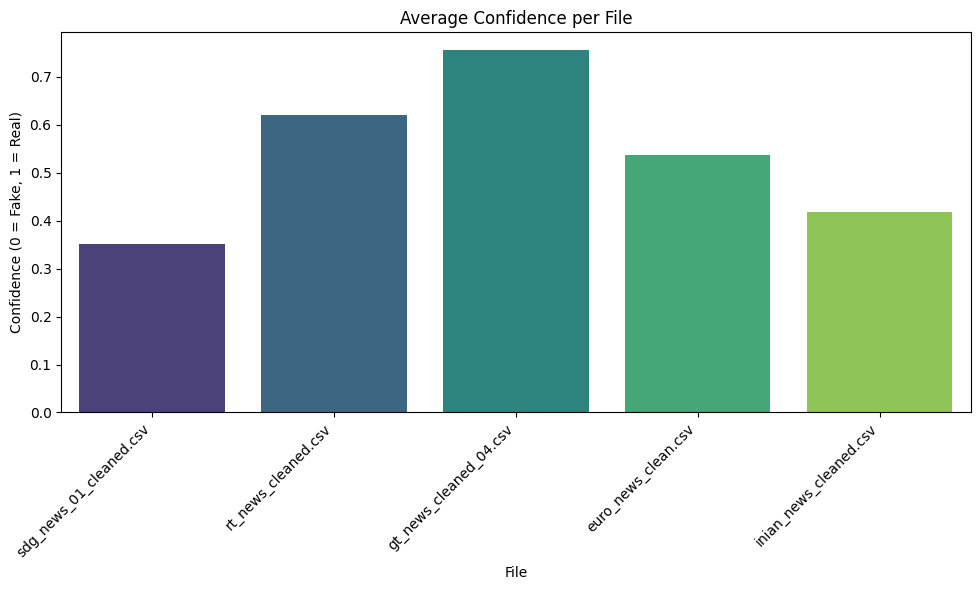

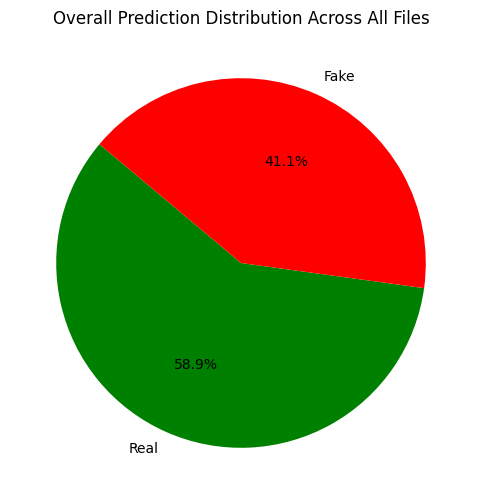

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary from previous step
summary_df = pd.read_csv("/kaggle/working/predictions_summary.csv")

# 1️⃣ Bar chart: Fake vs Real per file
plt.figure(figsize=(10,6))
sns.barplot(data=summary_df.melt(id_vars="File", value_vars=["Real Count","Fake Count"]),
            x="File", y="value", hue="variable")
plt.title("Fake vs Real Predictions per File")
plt.ylabel("Article Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Prediction")
plt.tight_layout()
plt.show()

# 2️⃣ Bar chart: Average Confidence per file
plt.figure(figsize=(10,6))
sns.barplot(data=summary_df, x="File", y="Avg Confidence", palette="viridis")
plt.title("Average Confidence per File")
plt.ylabel("Confidence (0 = Fake, 1 = Real)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3️⃣ Pie chart: Overall Fake vs Real across all files
total_fake = summary_df["Fake Count"].sum()
total_real = summary_df["Real Count"].sum()

plt.figure(figsize=(6,6))
plt.pie([total_real, total_fake],
        labels=["Real","Fake"],
        autopct="%1.1f%%",
        colors=["green","red"],
        startangle=140)
plt.title("Overall Prediction Distribution Across All Files")
plt.show()
